In [2]:
!pip install tensorflow

# **Tensors**

In [3]:
import tensorflow as tf
x = tf.constant([[1,2],[2,4]])
print(x)


tf.Tensor(
[[1 2]
 [2 4]], shape=(2, 2), dtype=int32)


In [ ]:
5*x

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 5, 10],
       [10, 20]], dtype=int32)>

In [ ]:
x @ tf.transpose(x) #nghịch đảo


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 5, 10],
       [10, 20]], dtype=int32)>

In [ ]:
tf.concat([x, x, x], axis=0) #cộng dồn

<tf.Tensor: shape=(6, 2), dtype=int32, numpy=
array([[1, 2],
       [2, 4],
       [1, 2],
       [2, 4],
       [1, 2],
       [2, 4]], dtype=int32)>

In [ ]:
tf.reduce_sum(x) #xóa hết shape

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [ ]:
tf.convert_to_tensor([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [ ]:
tf.reduce_sum([1,2,3])

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [ ]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


# **Variables**

In [ ]:
var = tf.Variable([0.0, 0.0, 0.0]) #tensors bất biến còn variables thay đổi nên dùng để gán giá trị

In [ ]:
var.assign([1, 2, 3])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [ ]:
var.assign_add([1, 1, 1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

# **Graph and Functions**

In [ ]:
@tf.function ## chuyển qua python function, not tensorflow function nên khi print value ra thì k print được array
def my_func(x):
  print('Tracing.\n')
  return tf.reduce_sum(x)

In [ ]:
x = tf.constant([1, 2, 3])
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [ ]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
my_func(x)
# You can export these graphs, using tf.saved_model,
# to run on other systems like a server or a mobile device, no Python installation required.

<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

# **Modules, Layer and Model**
Module manage variable and function through tf.Module

In [ ]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight


In [ ]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

In [ ]:
# Save model
save_path = './saved'
tf.saved_model.save(mod, save_path)

In [ ]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

The tf.keras.layers.Layer and tf.keras.Model classes build on tf.Module providing additional functionality
and convenience methods for building, training, and saving models

# **Training Loops**

In [1]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

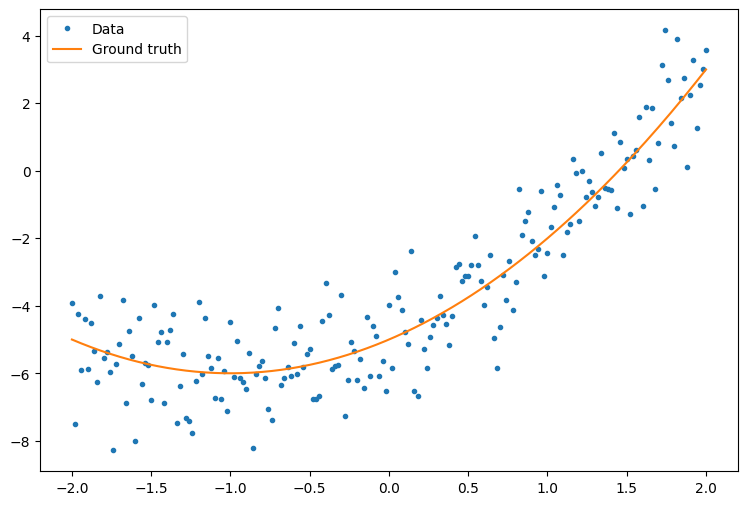

In [ ]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

In [ ]:
# Create a quadratic model with randomly initialized weights and a bias:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

In [ ]:
# First, observe your model's performance before training:
quad_model = Model()

In [ ]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

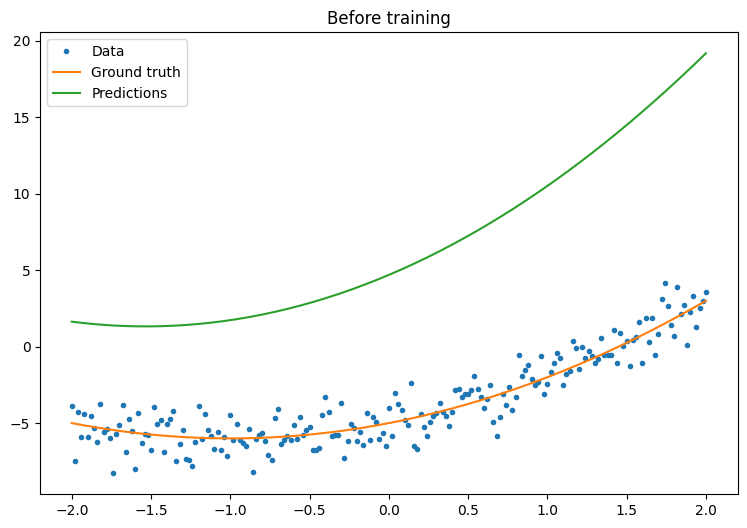

In [ ]:
plot_preds(x, y, f, quad_model, 'Before training')

In [ ]:
# Now, define a loss for your model using MSE:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 55.650
Mean squared error for step 10: 9.773
Mean squared error for step 20: 4.084
Mean squared error for step 30: 2.157
Mean squared error for step 40: 1.475
Mean squared error for step 50: 1.239
Mean squared error for step 60: 1.161
Mean squared error for step 70: 1.133
Mean squared error for step 80: 1.124
Mean squared error for step 90: 1.120




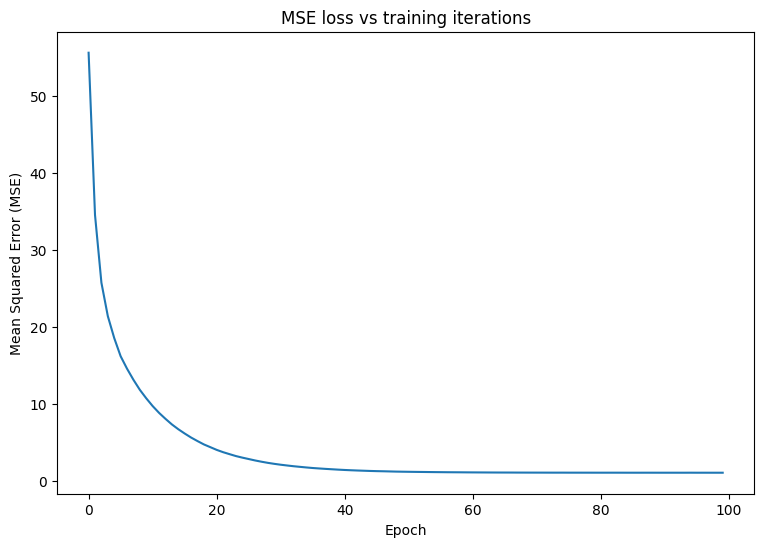

In [ ]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

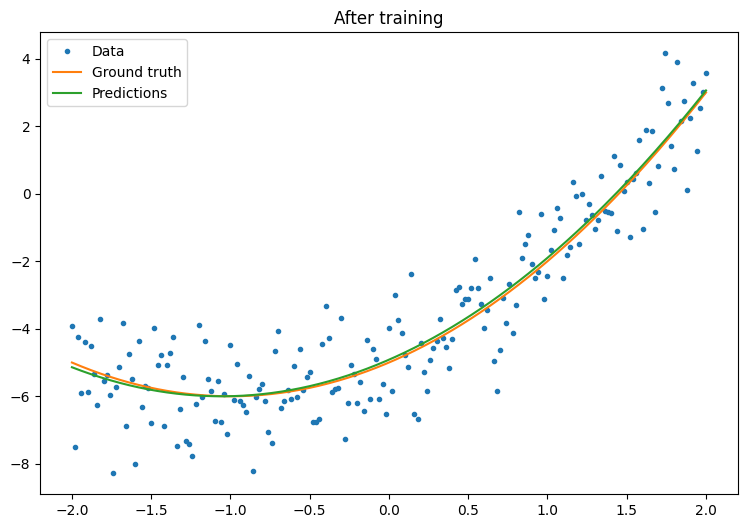

In [ ]:
# Now, observe your model's performance after training:
plot_preds(x, y, f, quad_model, 'After training')

That's working, but remember that implementations of common training utilities are available in the tf.keras module. So, consider using those before writing your own.
To start with, the Model.compile and Model.fit methods implement a training loop for you:

In [ ]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])

In [ ]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

new_model.save('./my_new_model')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


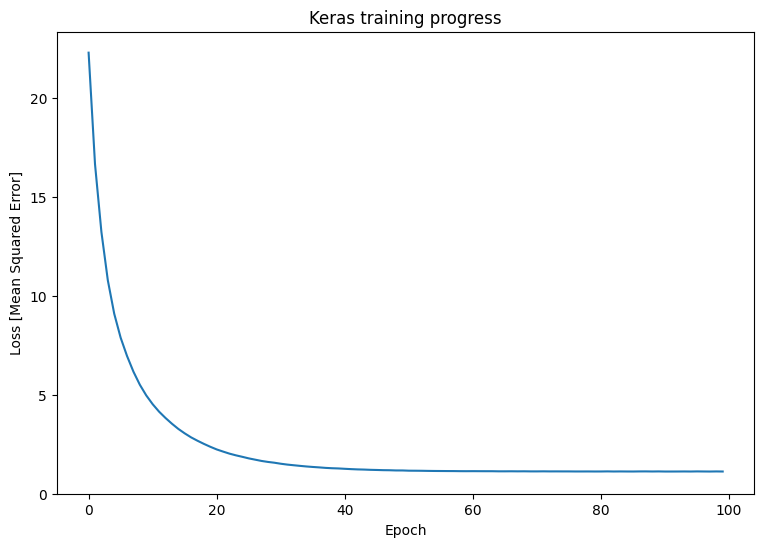

In [ ]:
# Observe your Keras model's performance after training:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');


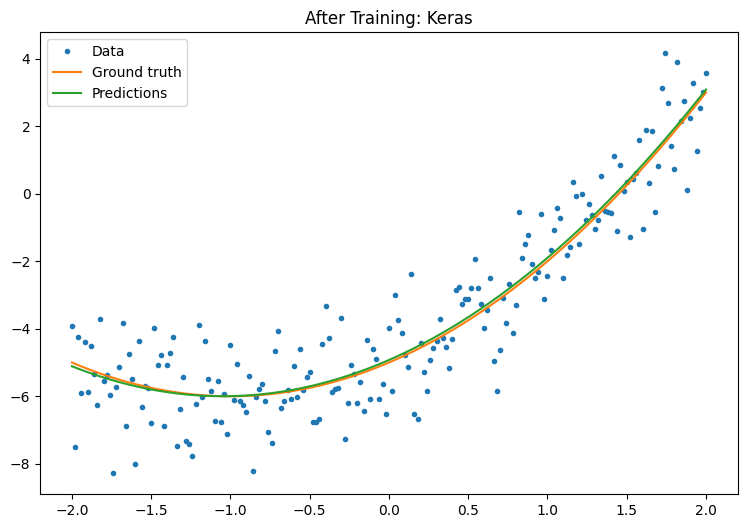

In [ ]:
plot_preds(x, y, f, new_model, 'After Training: Keras')